In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1. Загрузка данных

Загрузим данные поездок за май 2016 года и посмотрим на них:

In [4]:
%%time
data_filename = 'yellow_tripdata_2016-05.csv'
data = pd.read_csv('Data/' + data_filename)

CPU times: user 23.1 s, sys: 1.49 s, total: 24.5 s
Wall time: 24.5 s


In [5]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


In [6]:
data.shape

(11836853, 19)

В базе содержатся данные о 11,8 млн поездок такси, каждая поездка имеет 19 признаков - время и координаты начала и конца поездки, кол-во пассажиров, расстояние и т.д.

# 2. Фильтрация данных

Произведем фильтрацию данных: удалим поездки с нулевым временем, нулевым расстоянием, нулевым количеством пассажиров и координатами начала за пределами Нью-Йорка

In [7]:
west = -74.25559
east = -73.70001
south = 40.49612
nord = 40.91553

In [10]:
bad_indices = ((data['tpep_pickup_datetime'] == data['tpep_dropoff_datetime']) | (data['passenger_count'] == 0) |\
             (data['trip_distance'] == 0) | (data['pickup_longitude'] < west) | (data['pickup_longitude'] > east) |\
               (data['pickup_latitude'] < south) | (data['pickup_latitude'] > nord)).nonzero()
print(type(bad_indices), len(bad_indices), len(bad_indices[0]))

<class 'tuple'> 1 210332


In [11]:
data.drop(bad_indices[0], inplace = True)
data.shape

(11626521, 19)

Видим, что удалились данные около 200000 поездок - около 2% всей выборки

Теперь уберем минуты и секунды во времени начала поездки:

In [12]:
data['tpep_pickup_datetime'] = pd.Series([(str(x))[:13] for x in data['tpep_pickup_datetime'].values], index = data.index)
#Дата без минут и секунд занимает 13 символов

In [13]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01 00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01 00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01 00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01 00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01 00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


# 3. Агрегация данных

Разобьем прямоугольник Нью-Йорка на 50х50 маленьких прямоугольников и посчитаем количество поездок из каждого с помощью функции scipy.stats.binned_statistic2d

In [15]:
from scipy import stats

In [16]:
statistic, x_edge, y_edge, binnumber = stats.binned_statistic_2d(data['pickup_longitude'], data['pickup_latitude'], None,\
statistic = 'count', bins = [np.linspace(west, east, 51), np.linspace(south, nord, 51)], expand_binnumbers = True)

statistic - это кол-во поездок из каждой ячейки, x_edge, y_edge - границы ячеек по долготе и широте соответствнно, binnumber - горизонтальные и вертикальные номера ячеек для каждой поездки. Сделаем массив cellnumber, в котором будут содержаться номера ячеек для каждой поездки, с нумерацией ячеек как в файле regions.csv:

In [17]:
cellnumber = (binnumber[0] - 1) * 50 + binnumber[1]
data['cell'] = cellnumber

In [19]:
from datetime import datetime

Теперь для каждой пары час-ячейка посчитаем, сколько поездок было совершено в этот час из этой ячейки и запишем это в таблицу agregated

In [44]:
time_and_cell = list(zip(data.tpep_pickup_datetime.values, data.cell.values))

In [45]:
from collections import Counter
c = Counter(time_and_cell)

In [46]:
%%time
from datetime import datetime, timedelta
d = datetime(2016, 5, 1, 0)
hour = timedelta(0, 3600)
while d.month == 5:
    for cell in range(1, 2501):
        if (str(d)[:13], cell) not in c:
            c[(str(d)[:13], cell)] = 0
    d += hour

CPU times: user 5.86 s, sys: 89.7 ms, total: 5.95 s
Wall time: 5.95 s


In [48]:
print(len(c))

1860000


In [49]:
time = np.array([x[0] for x in c])
cell = np.array([x[1] for x in c])
num_trips = np.array([c[x] for x in c])

Посмотрим на первые 5 строк из таблицы:

In [50]:
agregated = pd.DataFrame()
agregated['time'] = time
agregated['cell'] = cell
agregated['num_trips'] = num_trips
agregated.head()

,time,cell,num_trips
0,2016-05-28 14,515,0
1,2016-05-19 22,74,0
2,2016-05-03 02,1908,0
3,2016-05-14 11,1232,781
4,2016-05-02 13,1084,0


# 4. Посмотрим количесива поездок

Посмотрим, сколько было совершено поездок из ячейки, содержащей Empire State Building. Координаты Empire State Building: -73.985126 долготы и 40.748527  широты

In [76]:
print(ESB_x, ESB_y)

24 30


In [84]:
ESB_coord = (-73.985126, 40.748527)
ESB_x = int((ESB_coord[0] - west) / ((east - west) / 50))
ESB_y = int((ESB_coord[1] - south) / ((nord - south) / 50))
ESB_count = statistic[ESB_x][ESB_y]
print(int(ESB_count), " поездок из ячейки")

489489  поездок из ячейки


Построим график поездок из данной ячейки:

In [127]:
ESB_cell = ESB_x * 50 + ESB_y + 1
ESB_trips = agregated[agregated.cell == ESB_cell]
ESB_trips.sort_values(by= 'time', inplace=True)
trip_time = ESB_trips['time'].values
trip_time = [(int(x[8:10]) - 1) * 24 + int(x[-2:]) for x in trip_time]
num_trips = ESB_trips.num_trips.values

/home/ubuntu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


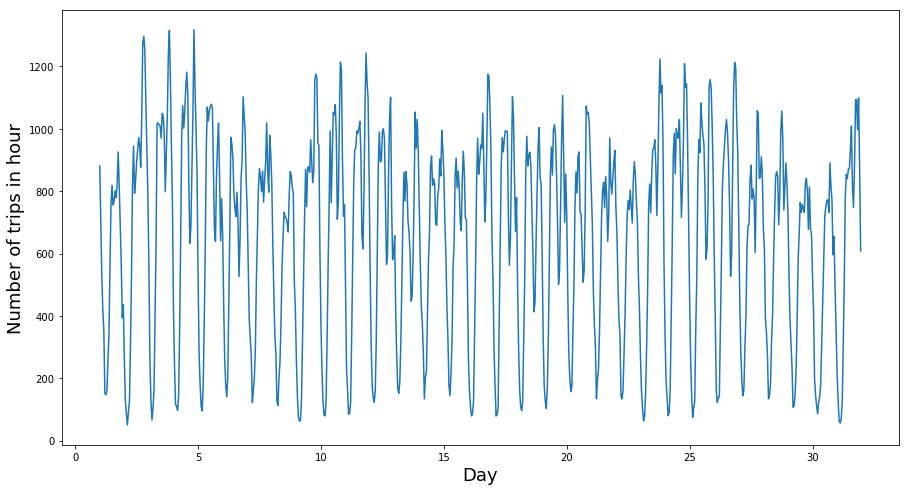

In [135]:
plt.figure(figsize=(15, 8))
plt.plot(np.array(trip_time) / 24 + 1, num_trips)
plt.xlabel('Day', fontsize=18)
plt.ylabel('Number of trips in hour', fontsize=18)
plt.show()

График имеет явно выраженную суточную сезонность и заметную недельную сезонность - в выходные поездок чуть меньше.

Теперь посмотрим кол-во пар (час-ячейка), в которых не было ни одной поездки:

In [54]:
nz = agregated['num_trips'].nonzero()[0]
no_trips = agregated.shape[0] - nz.shape[0]
print(no_trips)

1718238


Общее кол-во всевозможных пар час-ячейка - 1860000, то есть около 92% значений таблицы - нули. Значит, данные распределениы по координатам и по часам очень неравномерно

# 5. Сохранение результатов

Сохраним отфильтрованные данные, статистику по ячейкам и таблицу по парам час-ячейка:

In [36]:
data.to_csv("Data/Prepared/" + data_filename, sep = ',', index = False)

In [37]:
np.savetxt('Data/Prepared/' + data_filename[:-4] + '_statistic.txt', statistic)

In [38]:
agregated.to_csv("Data/Prepared/" + data_filename[:-4] + "_agregated.csv", sep = ',', index = False)

Чтобы проверить, что всё сохранилось нормально, загрузим сохраненные данные и посмотрим на них:

In [39]:
saved_data = pd.read_csv("Data/Prepared/" + data_filename)
saved_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,cell
0,1,2016-05-01 00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80,1233
1,2,2016-05-01 00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68,1180
2,2,2016-05-01 00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36,1180
3,2,2016-05-01 00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96,1173
4,2,2016-05-01 00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76,1130


In [40]:
saved_st = np.loadtxt('Data/Prepared/' + data_filename[:-4] + '_statistic.txt')
print saved_st

[[ 0.  0.  0. ...,  0.  5.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [41]:
saved_agr = pd.read_csv("Data/Prepared/" + data_filename[:-4] + "_agregated.csv")
saved_agr.head()

,time,cell,num_trips
0,2016-05-14 12,1828,1
1,2016-05-10 19,2134,0
2,2016-05-23 11,242,0
3,2016-05-12 21,2295,0
4,2016-05-26 05,1007,0


Обработанные данные сохранились корректно.